## Portfolio Optimization


In [668]:
import pandas as pd 
import numpy as np 
import yfinance as yf 
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date
import scipy.optimize as sco 

In [669]:
tickers = sorted(['AAPL',# Apple Inc. - Information Technology
                'JNJ',   # Johnson & Johnson - Healthcare
                'JPM',   # JPMorgan Chase & Co. - Financials
                'XOM',   # Exxon Mobil Corporation - Energy
                'TSLA',  # Tesla. - Consumer Discretionary
                'UNP', ] # Union Pacific Corporation - Industrials
)


#Define start and end date 
start_date = dt.datetime(2023,1,2)
end_date = dt.datetime.today().date()

#Down the adj close price data
data = yf.download(tickers, start = start_date, end = end_date, auto_adjust= False, multi_level_index=False)['Adj Close']

#Number of assets
noa = len(tickers)

#Risk Free rate for later computation of the Sharpe Ratio
#Risk Free rate
from fredapi import Fred
fred = Fred(api_key = '58d5fc9d57b922a18576edf7c5210972')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)


[*********************100%***********************]  6 of 6 completed


0.043899999999999995


#### Plot the daily Close price over the Historical Time Period

Text(0.5, 1.0, 'Daily Price of the Securities Over the Historical Peirod')

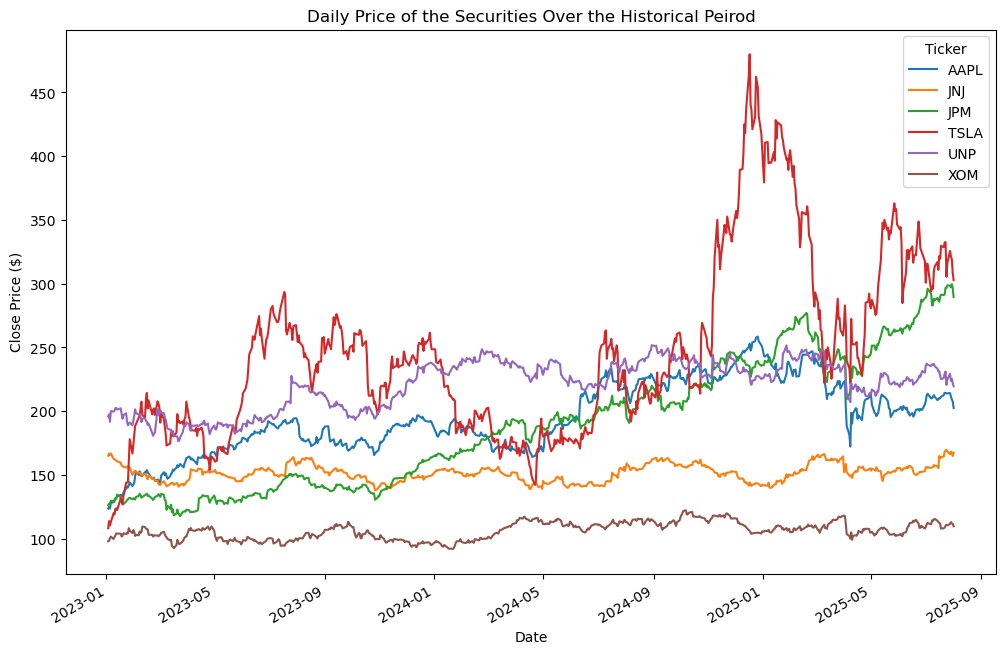

In [670]:
data.plot(figsize=(12,8))
plt.ylabel('Close Price ($)')
plt.xlabel('Date')
plt.title('Daily Price of the Securities Over the Historical Peirod')

#### Compute log returns and plot

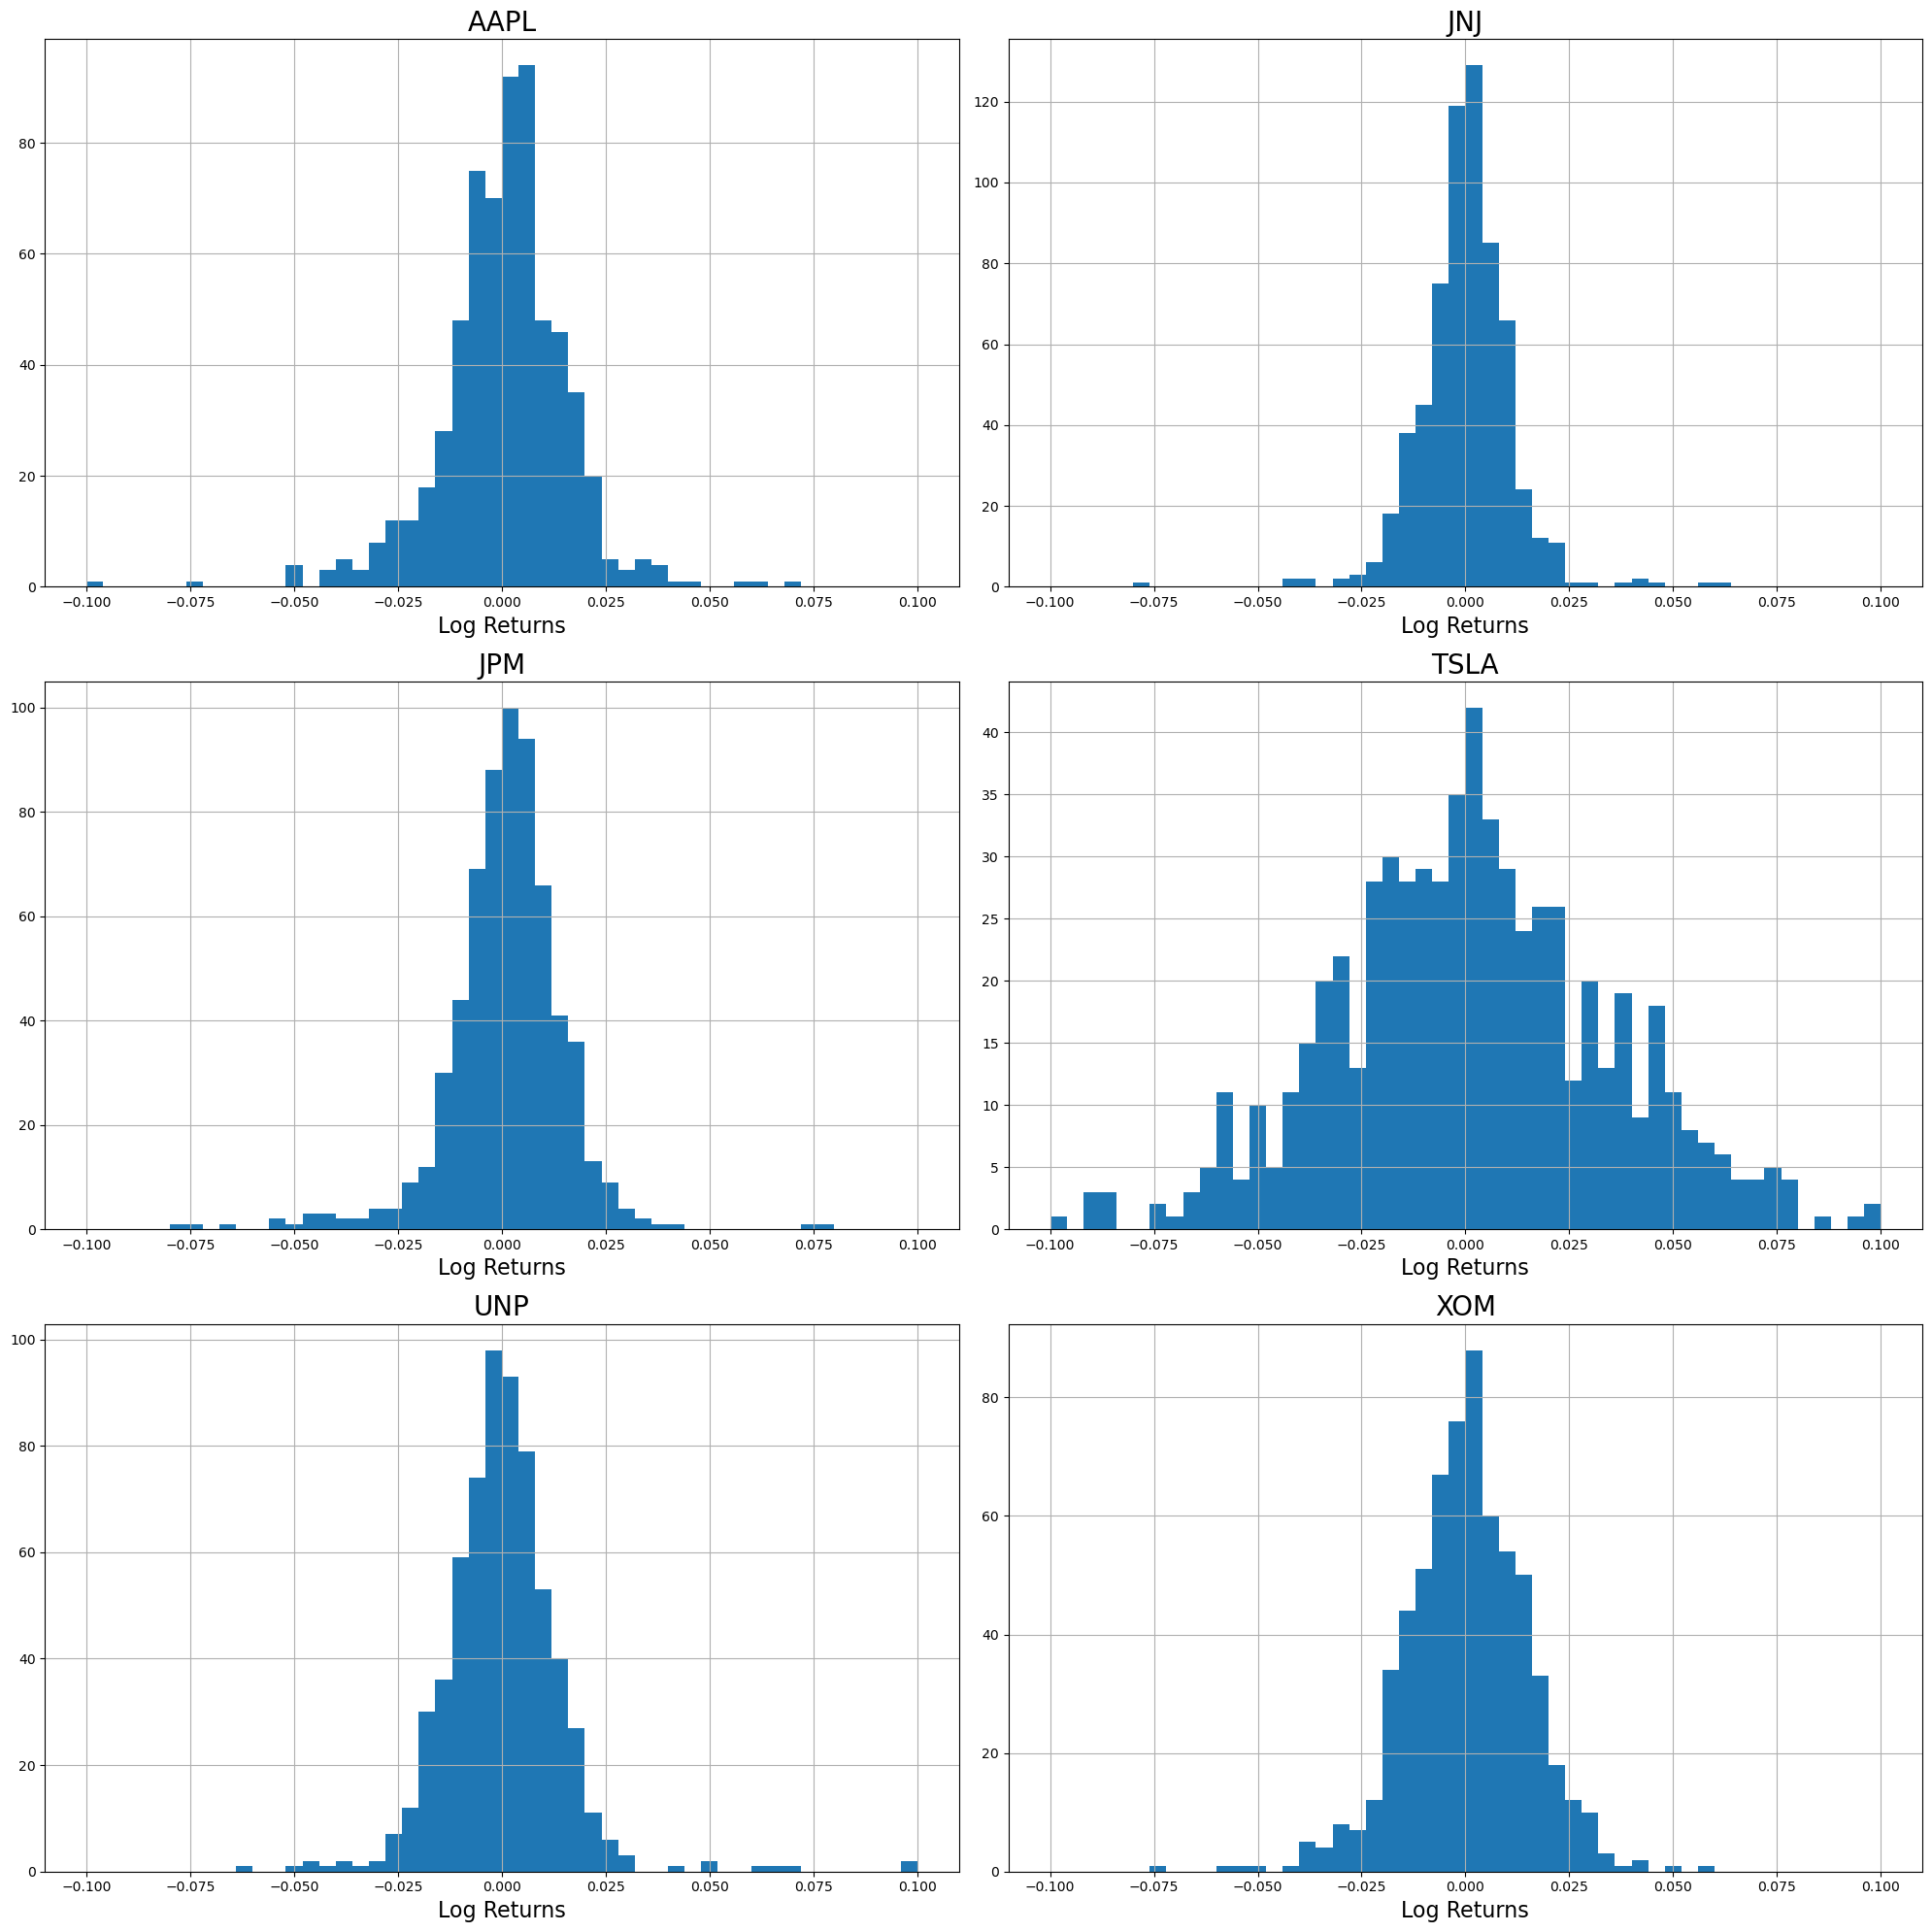

In [671]:
#Compute the returns
rets = np.log(data/data.shift(1))
rets.dropna(inplace=True)
axes = rets.hist(bins= 50, figsize = (20,20), range= (-0.1, 0.1))
for ax, col in zip(axes.flatten(), rets.columns):
    ax.set_xlabel('Log Returns', fontsize = 16)
    ax.set_title(col, fontsize=20)
plt.tight_layout()

#### Plot a bar charts of Mean returns and Standard deviation

<class 'pandas.core.series.Series'>


Text(0.5, 1.0, 'Daily Mean ROR for the Secutiries')

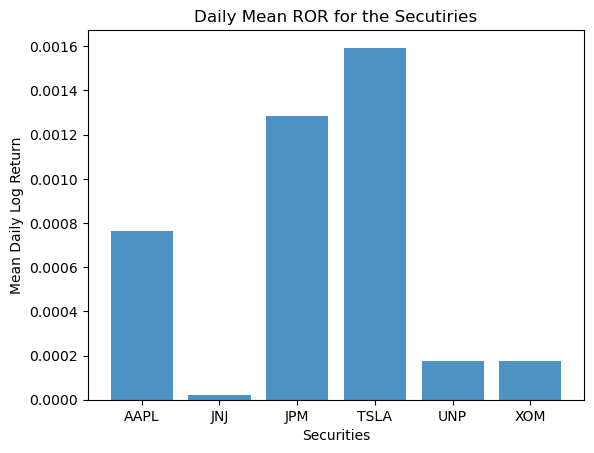

In [672]:
# Compute the Mean Returns
mean_returns = rets.mean()
print(type(mean_returns))
plt.bar(mean_returns.index, mean_returns.values, alpha = 0.8)
plt.xlabel('Securities')
plt.ylabel('Mean Daily Log Return')
plt.title('Daily Mean ROR for the Secutiries')


#### Compute and Plot Standard Deviation

Text(0, 0.5, 'Standard Deviation')

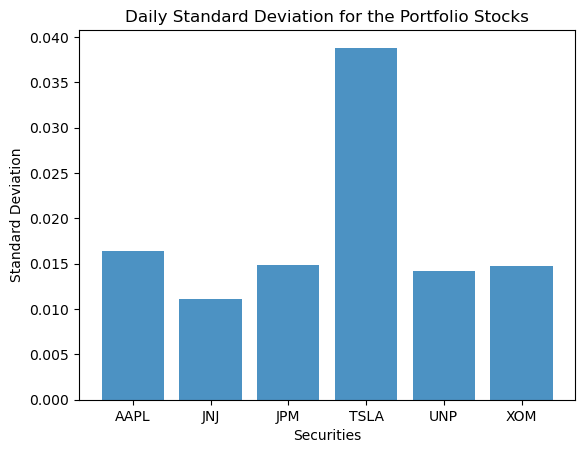

In [673]:
#Compute Standard deviation and then plot
std = rets.std() 
plt.bar(std.index, std.values, alpha = 0.8)
plt.title("Daily Standard Deviation for the Portfolio Stocks")
plt.xlabel('Securities')
plt.ylabel('Standard Deviation')

#### Monte Carlo Simulation

In [674]:
#Function to compute the portfolio return
def port_ret(weights):
    return np.sum(weights * rets.mean()) * 252

#Function to compute the volatility 
def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() *252, weights)))


#Define empty lists to assign values to
irets = []
ivols = []
num_simulations = 10000

#Run the simulation
for i in range(num_simulations):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    irets.append(port_ret(weights))
    ivols.append(port_vol(weights))

irets = np.array(irets)
irets_min = irets.min()
irets_max = irets.max()
ivols = np.array(ivols)

#Calculate Sharpe ratio
sharpe = (irets - [risk_free_rate] * num_simulations)/ ivols


#### Define the Bounds and Constraints for optimizations & Initial Guess

In [675]:
#Define Minimum sharpe. This is the function we are going to minimize 
def minimum_sharpe(weights):
    return (-1) * ((port_ret(weights) - risk_free_rate )/ (port_vol(weights)))

#Equality Constraint where the sum of the weights must be equal to 1  
cons= ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

#This sets the upper and lower bounds for the weightings. No negative values means that we cant short the investment
bnds = tuple((0,0.5) for x in range(noa))

#Set an Initial Guess for the weights
weights_initial = [1 / noa] * noa
print(weights_initial)




[0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]


#### Maximum Sharpe Optimization

In [676]:
#Optimization for negative Sharpe 
optimize_s = sco.minimize(
    minimum_sharpe,
    weights_initial,
    method = 'SLSQP',
    bounds = bnds,
    constraints = cons

)

#Obtain the Optimal selection weight, volatility, expected return and sharpe 
optimial_weight_s  = optimize_s['x']
optimal_expected_return_s = port_ret(optimial_weight_s).round(3)
optimal_volatility_s = port_vol(optimial_weight_s).round(3)
optimal_sharpe = (optimal_expected_return_s - risk_free_rate) / optimal_volatility_s

optimal_portfolio = pd.DataFrame({
    'Volatility': optimal_volatility_s,
    'Return': optimal_expected_return_s,
    'Sharpe': optimal_sharpe}, index=range(1)
)

print('-' * 80)
print('Optimal Portfolio For Maximum Sharpe')
print('=' * 80)
print(optimal_portfolio)
print('=' * 80)


--------------------------------------------------------------------------------
Optimal Portfolio For Maximum Sharpe
   Volatility  Return  Sharpe
0         0.2    0.26    1.09


#### Minimum Volatility Optimization

In [677]:
#Optimization for Lowest Volatility
optimize_v = sco.minimize(
    port_vol,
    weights_initial,
    method = 'SLSQP',
    bounds = bnds,
    constraints = cons

)
#Obtain the Optimal selection weight, volatility, expected return and sharpe 
optimial_weight_v  = optimize_v['x']
optimal_expected_return_v = port_ret(optimial_weight_v).round(3)
optimal_volatility_v = port_vol(optimial_weight_v).round(3)
sharpe_low_v = (optimal_expected_return_v - risk_free_rate) / optimal_volatility_v

optimal_portfolio_v = pd.DataFrame({
    'Volatility': optimal_volatility_v,
    'Return': optimal_expected_return_v,
    'Maximum Sharpe': sharpe_low_v}, index=range(1)
)
print(optimize_v['x'])
print('-' * 80)
print('Optimal Portfolio For Low Volatility')
print('=' * 80)
print(optimal_portfolio_v)
print('=' * 80)



[1.54552009e-01 4.73436811e-01 1.03689982e-01 1.02999206e-18
 1.04841712e-01 1.63479486e-01]
--------------------------------------------------------------------------------
Optimal Portfolio For Low Volatility
   Volatility  Return  Maximum Sharpe
0        0.13    0.08            0.25


### Efficient Frontier Computation

In [678]:
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - tret},   #This first constraint fixes the return level 
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

bnds = tuple((0,1) for _ in range(noa))

#Create return levels to evaluate minimal volatility. I use the upper and lower bounds of the monte carlo sim here.
trets_min = irets_min #- 0.02
trets_max = irets_max + 0.05
trets = np.linspace(trets_min, trets_max, 50) 

#Run optimization for minium return at each volatility level
tvols = []
for tret in trets:
    res = sco.minimize(
        port_vol, 
        weights_initial,
        bounds= bnds,
        constraints = cons
        )
    tvols.append(res['fun'])   #This returns the value of the objective function (Volatilty) we dont want the weights in this case 
tvols = np.array(tvols)



#### Capital Allocation Line

In [679]:
#Adding the Capital Market Line 
import scipy.interpolate as sci

ind = np.argmin(tvols)          #Index Position of Minimum Volatility
evols = tvols[ind:]             #Select relevant volatility values
erets = trets[ind:]             #Select relevant return values
tck = sci.splrep(evols, erets)  #Cubic Splines interpolation of values

def f(x):                                                          # Returns an interpolated return for a given Volatility
    '''Efficient frontier function (splines approximation). ''' 
    return sci.splev(x, tck, der=0)
def df(x):                                                         # Gives the slope of efficient frontier at any given volatility 
    '''First derivative of efficient frontier function. '''
    return sci.splev(x, tck, der=1)


#Mathematical Condition for the capital allocation line 
def equations(p , rf = risk_free_rate):                            
    eq1 = rf - p[0]                 #y intersection x= 0           a = rf
    eq2 = rf + p[1]*p[2]-f(p[2])    #Eq of capital market line     a + bx = f(x)
    eq3 = p[1] - df(p[2])           #Ensures CML is tangent        b = f'(x)
    return eq1, eq2, eq3 

#Solves for three variables p[0] = risk free rate, p[1] = slope of CML p[2] = Volatility of the point of tangency

opt = sco.fsolve(equations, [risk_free_rate, 0.5, 0.15])  #Solve the system of Equations 

cx = np.linspace(0, trets_max)


#### Efficient Frontier Plot

0.39782445425583657


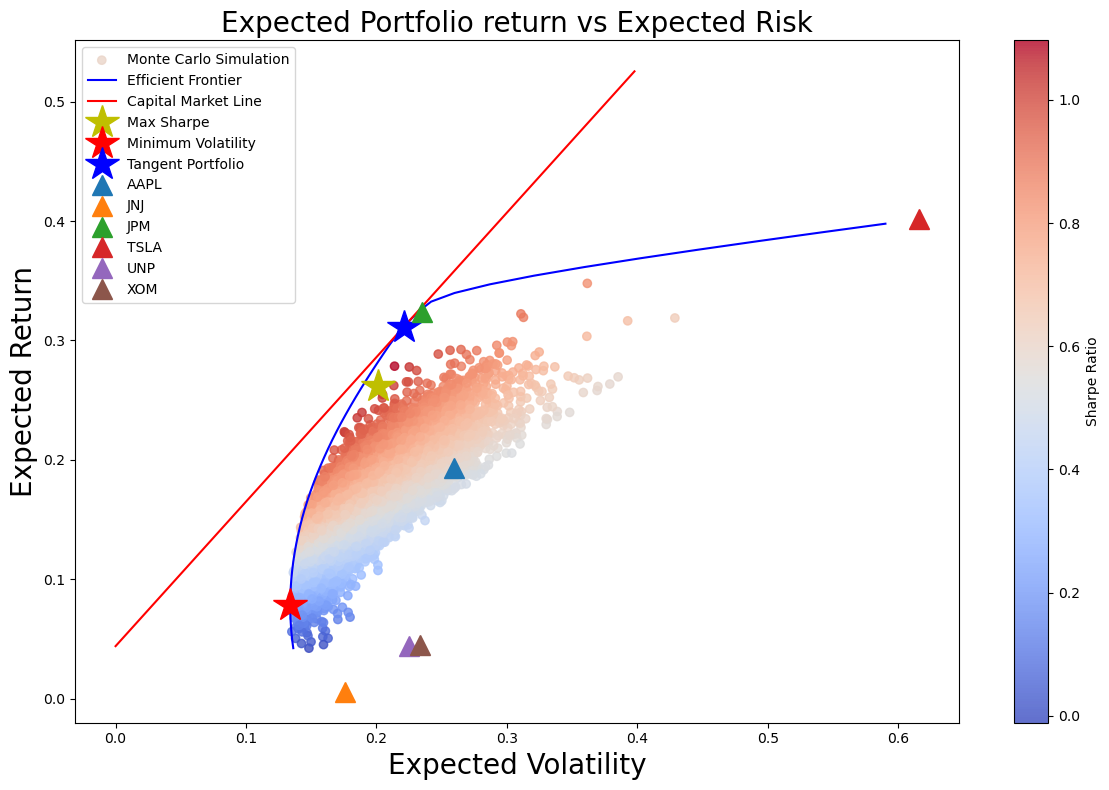

In [680]:
#Create Portfolio Optimization Plot 
plt.figure(figsize=(12,8))
plt.scatter(x= ivols, y=  irets, c= sharpe, cmap = 'coolwarm', marker ='o', alpha = 0.8, label = 'Monte Carlo Simulation')
plt.plot(tvols, trets, 'b', lw=1.5, label = 'Efficient Frontier')
plt.plot(cx, opt[0]+ opt[1]* cx, 'r', lw =1.5, label = 'Capital Market Line')
plt.plot(optimal_volatility_s, optimal_expected_return_s, 'y*', markersize = 25 , label = 'Max Sharpe' )
plt.plot(optimal_volatility_v, optimal_expected_return_v, 'r*', markersize = 25, label = 'Minimum Volatility')

plt.xlabel('Expected Volatility', fontsize = 20)
plt.ylabel('Expected Return', fontsize = 20)
plt.title('Expected Portfolio return vs Expected Risk', fontsize = 20)
plt.colorbar(label = 'Sharpe Ratio')

plt.plot(opt[2], f(opt[2]), 'b*', markersize = 25, label = 'Tangent Portfolio')
plt.legend()
plt.tight_layout()
#plt.ylim([0, 1])
#plt.xlim([0, 0.6])
print(trets_max)

for tick in mean_returns.index:
    label = str(tick)
    plt.plot(std[tick]* np.sqrt(252), mean_returns[tick]*252, '^' , markersize = 15 ,label = label)
    plt.legend()


### Getting the Weight of the optimal tangent portfolio

In [681]:
cons = ({'type' : 'eq', 'fun' : lambda x: port_ret(x) - f(opt[2])},   #Fixes the return to the optimal tangent portfolio return
        {'type' : 'eq', 'fun' : lambda x: np.sum(x) - 1})

bnds = tuple((0,1) for _ in range(noa))
res = sco.minimize(port_vol,
                   weights_initial,
                   constraints = cons,
                   bounds = bnds)

optimal_weight_t = res['x'].round(3)

tangent_optimal = pd.DataFrame({
    'Volatility': opt[2],
    'Return': f(opt[2]),
    'Maximum Sharpe': round(((f(opt[2]) - risk_free_rate)/ opt[2]),2)
}, index = range(1))


print('-' * 80)
print('Optimal Tangent Porfolio')
print('=' * 80)
print(tangent_optimal)
print('=' * 80)


--------------------------------------------------------------------------------
Optimal Tangent Porfolio
   Volatility  Return  Maximum Sharpe
0        0.22    0.31            1.21


### Weightings Of Optimized Portfolio 

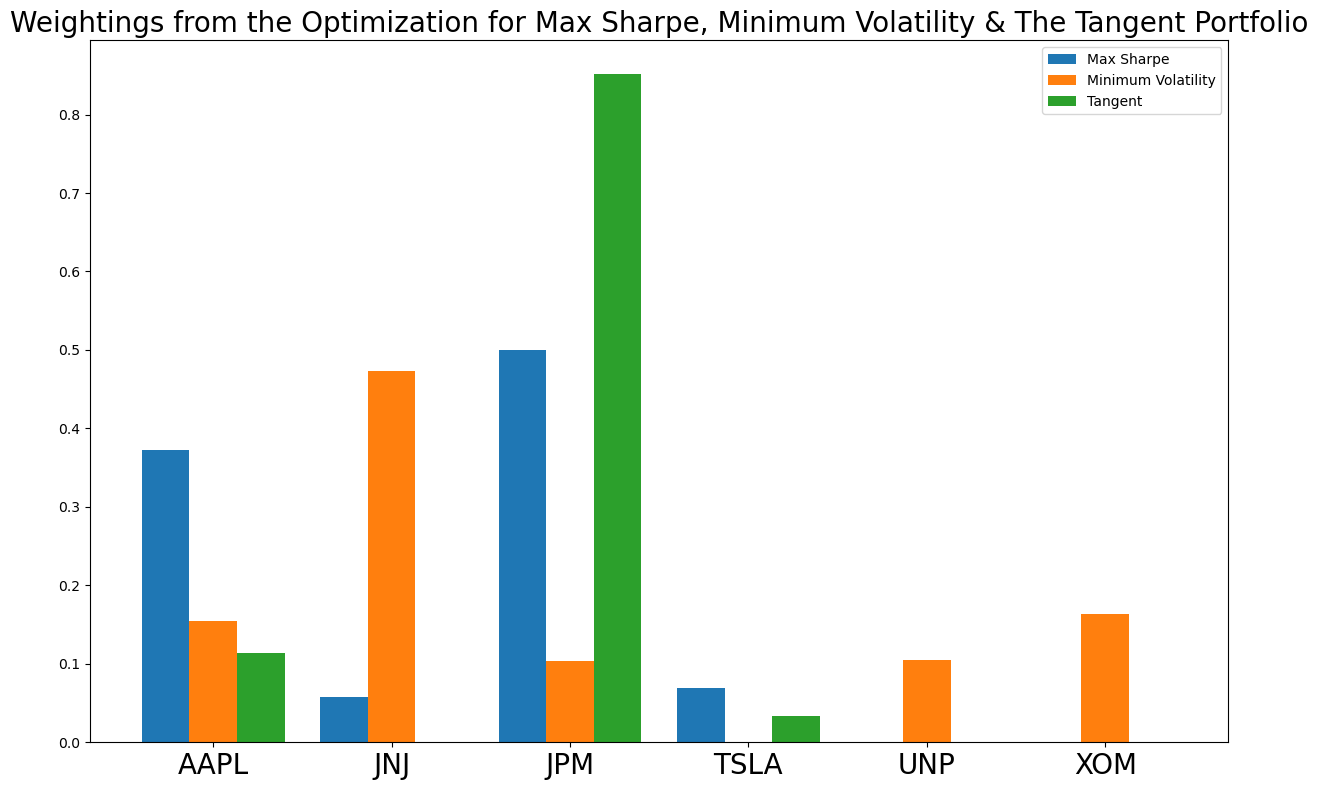

In [682]:
n = 1 #Max Sharpe data set
t = 3 # Number of datasets
d = noa # number of bars
w = 0.8 #Width of the bars

x_values_1 = [t*element + w*n for element in range(d)]

n = 2 #Minimum Volatility data set
t = 3 # Number of datasets
d = noa # number of bars
w = 0.8 #Width of the bars

x_values_2 = [t*element + w*n for element in range(d)]

n = 3 #Tangent Portolio data set
t = 3 # Number of datasets
d = noa # number of bars
w = 0.8 #Width of the bars

x_values_3 = [t*element + w*n for element in range(d)]

#Middle of x_values for xticks 
middle_x = [(a+b+c)/ 3 for a,b,c in zip(x_values_1, x_values_2, x_values_3)]

plt.figure(figsize= (12,8))
ax = plt.subplot()
plt.bar(x_values_1, optimial_weight_s, label = 'Max Sharpe')
plt.bar(x_values_2, optimial_weight_v, label= 'Minimum Volatility')
plt.bar(x_values_3, optimal_weight_t, label = 'Tangent')
plt.title('Weightings from the Optimization for Max Sharpe, Minimum Volatility & The Tangent Portfolio', fontsize= 20)
ax.set_xticks(middle_x)
ax.set_xticklabels(tickers, fontsize =20)
plt.legend()
plt.tight_layout()
plt.show()